In [1]:
#Importing libraries
import cv2
import glob
import os
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score , confusion_matrix
from sklearn import preprocessing

#tensorflow libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model, Sequential
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [3]:
# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 10

# Load the DataFrame
path = "G:/GitHub/Zootopia/animaldetect/species"
data = {"imgpath": [], "labels": []}
category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path, folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)
df = pd.DataFrame(data)

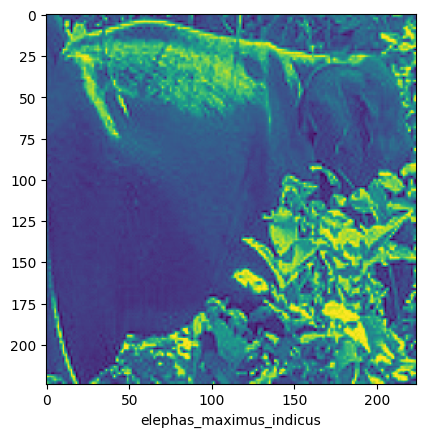

In [7]:
filepath = "G:/GitHub/Zootopia/animaldetect/species/elephas_maximus_indicus"

for img_path in os.listdir(filepath):
    img = cv2.imread(os.path.join(filepath, img_path), 0)
    plt.imshow(img)
    plt.xlabel(filepath.split("/")[-1])
    plt.show()   
    break

In [8]:
# Split the DataFrame into train, validation, and test sets
train_df, temp_df = train_test_split(df, train_size=0.70, shuffle=True, random_state=124)
valid_df, test_df = train_test_split(temp_df, train_size=0.70, shuffle=True, random_state=124)

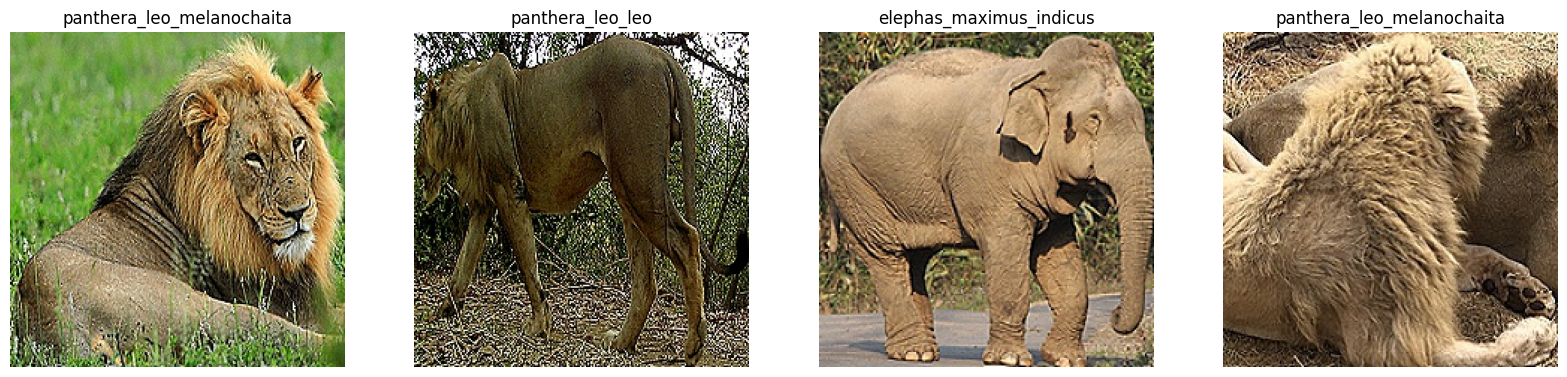

In [9]:
#Defining size of displayed image
plt.figure(figsize=(20,20))

#Displaying images from test dataframe
for i, row in test_df.sample(n=4).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

In [10]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df["labels"])
valid_labels = label_encoder.transform(valid_df["labels"])
test_labels = label_encoder.transform(test_df["labels"])

In [11]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoded vectors
num_classes = len(set(train_labels))
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [12]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define function to load and preprocess images
def load_images(image_paths):
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=IMAGE_SIZE)
        img = img_to_array(img)
        img = img / 255.0  # Normalize pixel values
        images.append(img)
    return np.array(images)

# Load and preprocess train, validation, and test images
train_images = load_images(train_df["imgpath"])
valid_images = load_images(valid_df["imgpath"])
test_images = load_images(test_df["imgpath"])

In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Define custom callback to stop training once the accuracy reaches 0.9
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get("val_accuracy")
        print(f"Validation Accuracy at epoch {epoch + 1}: {val_accuracy}")
        if val_accuracy >= 0.9:
            print("\nReached 90% accuracy! Stopping training...")
            self.model.stop_training = True

# Load the pre-trained VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Freeze the convolutional base
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation="relu"),
    Dense(num_classes, activation="softmax")
])

In [14]:
# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
# Train the model with the custom callback
history = model.fit(
    x=train_images, y=train_labels,
    validation_data=(valid_images, valid_labels),
    batch_size=BATCH_SIZE, epochs=EPOCHS,
    callbacks=[MyCallback()]
)

Epoch 1/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6013 - loss: 2.0887Validation Accuracy at epoch 1: 0.6864197254180908
338/338 ━━━━━━━━━━━━━━━━━━━━ 1304s 4s/step - accuracy: 0.6015 - loss: 2.0861 - val_accuracy: 0.6864 - val_loss: 0.9053
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8150 - loss: 0.4994Validation Accuracy at epoch 2: 0.7209876775741577
338/338 ━━━━━━━━━━━━━━━━━━━━ 1294s 4s/step - accuracy: 0.8150 - loss: 0.4994 - val_accuracy: 0.7210 - val_loss: 0.8442
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8905 - loss: 0.3331Validation Accuracy at epoch 3: 0.7308642268180847
338/338 ━━━━━━━━━━━━━━━━━━━━ 2651s 8s/step - accuracy: 0.8905 - loss: 0.3331 - val_accuracy: 0.7309 - val_loss: 0.9921
Epoch 4/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9198 - loss: 0.2236Validation Accuracy at epoch 4: 0.7586419582366943
338/338 ━━━━━━━━━━━━━━━━━━━━ 1399s 4s/step - accuracy: 0.9198 - loss: 0.2236 - val_accuracy: 0.7586 - v

In [17]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

22/22 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step - accuracy: 0.7260 - loss: 1.5463
Test Loss: 1.4884092807769775
Test Accuracy: 0.7424460649490356


In [18]:
# Save the model
model.save("animal_species_detect.h5")

In [19]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf

# Define your class labels
class_labels = ["elephas_maximus_borneensis", "elephas_maximus_indicus", "elephas_maximus_maximus", "elephas_maximus_sumatranus", "panthera_leo_leo", "panthera_leo_melanochaita", "panthera_onca", "panthera_pardus_delacouri", "panthera_pardus_fusca", "panthera_pardus_kotiya", "panthera_pardus_melas", "panthera_pardus_pardus", "panthera_pardus_tulliana", "panthera_tigris"]

# Function to preprocess image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0  # Normalize pixel values
    return image

# Function to predict class
def predict_image(image_path, model):
    image = preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)
    return predicted_class, confidence

# Example: Check another image and get prediction
image_path = "G:/GitHub/Zootopia/animaldetect/species/elephas_maximus_sumatranus/101991676_a.jpg"  # Replace with the path to your image
predicted_class, confidence = predict_image(image_path, model)
predicted_class_name = class_labels[predicted_class]
print("Predicted class:", predicted_class_name)
print("Confidence:", confidence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class: elephas_maximus_sumatranus
Confidence: 0.99743
